In [1]:
################################
# LIBRARIES
################################
from functionshelper import *
from functionssessions import *

from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Matplotlib settings
plt.style.use("seaborn")

params = {
    "font.family": "STIXGeneral",
    "mathtext.fontset": "stix",
    "axes.labelsize": 20,
    "legend.fontsize": 20,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "text.usetex": False,
    "figure.figsize": [10, 5],
    "axes.grid": True,
}

plt.rcParams.update(params)
plt.close("all")

# Apply the default theme
sns.set_theme()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
################################
# FUNCTIONS
################################

def get_timestamp(timestr, date, offset=0):
    return datetime.strptime(f'{date} {timestr}', '%Y-%m-%d %H:%M:%S') + timedelta(seconds=offset)

def add_secs(initial, secs):
    return initial + timedelta(seconds=secs)

def format_time(date, time_int):
    # convert int to str
    str_time = str(time_int)
    
    # Pad 5:00:00 to 05:00:00
    if len(str_time) < 6:
        str_time = '0' + str_time
    
    # Concatenate date and time
    str_time = date + ' ' + str_time
    
    # Convert string into date time object
    result = datetime.strptime(str_time, '%Y-%m-%d %H%M%S')
    
    return result

def get_calibrate_df():
    # Store all raw session dataframes in array
    calibrate_dfs = []

    # Get session files in folder
    folder = 'later-data/KalibreringAISweden/'
    session_files = sorted(os.listdir(folder))

    for i, file_name in enumerate(session_files):

        # Read individual sensor data
        raw_df = pd.read_csv(folder + '/' + file_name, skiprows=1)
        raw_df['Sensor'] = str(file_name[0])
        raw_df['Timestamp'] = raw_df['Time'].apply(lambda x: format_time('2021-12-14', x) + timedelta(hours=2))

        # Remove first 150 rows and last 30 rows
        raw_df = raw_df[150:]
        raw_df = raw_df[:-30]

        # Convert timestamp string column into datetime
        #raw_df["Timestamp"] = raw_df["Timestamp"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

        # Add to list
        calibrate_dfs.append(raw_df)

    # Combine all sensor dfs into one large dataframe
    calibrate_df = pd.concat(calibrate_dfs)
    calibrate_df.reset_index(drop=True, inplace=True)
    
    return calibrate_df

def print_outliers(s_df, station_quantiles, column):
    # Get session ids associated with
    outliers_dict = {}

    s_of_interest = list(station_quantiles[column].loc[station_quantiles[column].outliers > 0].index)
    soi_df = s_df.loc[s_df['Station'].isin(s_of_interest)]

    for station, grp in soi_df.groupby('Station'):    
        lower = station_quantiles[column]['lowerLimit'][station]
        upper = station_quantiles[column]['upperLimit'][station]
        outliers_dict[station] = grp.loc[(grp[column] <= lower) | (grp[column] >= upper)][['Session Id', column]].values

    # Print Session id's of interest
    outlier_ids = []

    print('=== OUTLIERS ===')

    for station, sessions in outliers_dict.items():
        print(f'{station}:')
        for session in sessions:

            outlier_ids.append(session[0])
            print(f'\t{session[0]} - {column} = {round(session[1], 2)}')

        print()

    print(f'Unique outliers: {sorted(set(outlier_ids))}')
    
    return outlier_ids


# Calibration A

In [3]:
# Get calibration dataframe
c_df = get_calibrate_df()
c_df = c_df[['Sensor', 'PM2.5']]

# figure folder
fig_folder = 'figures/PaperV1/Exploration/CalibrationA/'

## 1 Overall initial statistics

General statistics for the whole dataset.

In [4]:
grand_mean = c_df['PM2.5'].mean()
grand_median = c_df['PM2.5'].median()
grand_mode = c_df['PM2.5'].mode()
grand_std = c_df['PM2.5'].std()

c_df['PM2.5'].describe()

count    16840.000000
mean         0.616841
std          0.125099
min          0.280000
25%          0.530000
50%          0.610000
75%          0.700000
max          1.210000
Name: PM2.5, dtype: float64

## 2 Central tendency and variability

In [5]:
def mode(x):
    """The most common value."""
    return stats.mode(x)[0]

def x_range(x):
    """Difference between maximum and minimum."""
    return max(x) - min(x)

def sample_std(x):
    """Sample standard deviation."""
    return np.std(x, ddof=1)

def standard_error(x):
    """Sample standard error."""
    return sample_std(x) / np.sqrt(len(x))

central = c_df.groupby('Sensor').agg(
    {'PM2.5': 
     ['mean', 'median', mode, 'min', 'max', x_range, sample_std, standard_error]
    }
)

central.head()

PM2.5                                                           
            mean median  mode   min   max x_range sample_std standard_error
Sensor                                                                     
1       0.570914   0.56  0.52  0.31  0.86    0.55   0.105410       0.001988
2       0.641293   0.64  0.58  0.32  1.05    0.73   0.123486       0.002334
3       0.680662   0.68  0.70  0.33  1.21    0.88   0.145926       0.002753
4       0.582613   0.57  0.58  0.31  0.87    0.56   0.101945       0.001925
5       0.603684   0.60  0.56  0.31  0.95    0.64   0.109201       0.002061

**Comment**

Sensor 3 has the largest range and highest standard deviation. Sensor 1 has the lowest range. Sensor 4 has the lowest standard deviation.

## 3 Distribution
How is the data distributed?

### 3.1 Box plots

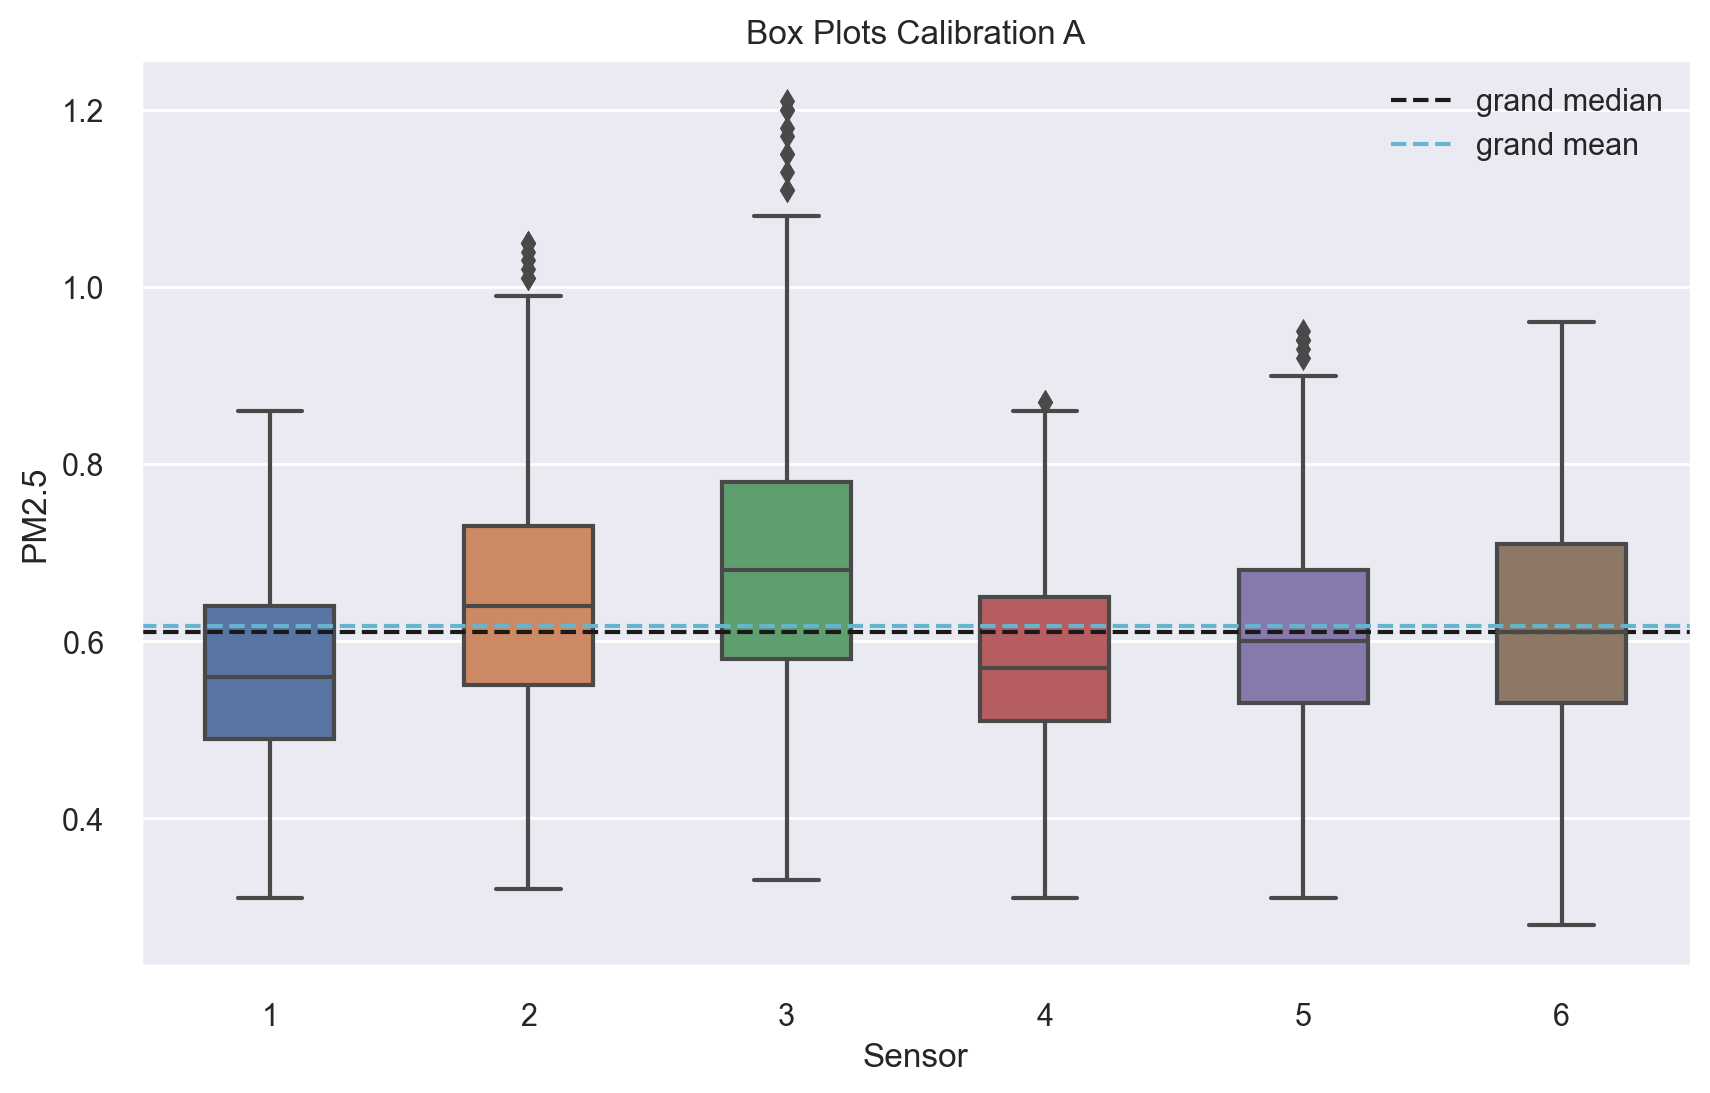

In [6]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

sns.boxplot(x='Sensor', y='PM2.5', data=c_df, width=0.5)

plt.axhline(c_df['PM2.5'].median(), c='k', linestyle='--', label='grand median')
plt.axhline(c_df['PM2.5'].mean(), c='c', linestyle='--', label='grand mean')

plt.legend()
plt.title('Box Plots Calibration A')
#plt.savefig('figures/PaperV1/Exploration/CalibrationA/box_plot.pdf')
plt.show()

**Comment**

From the boxplot, we can see that we have outliers. Mostly from sensors 2, 3, and 5. As the environment was controlled for during the calibration and assumed to be stable, these outliers are seen as errors in the sensor readings. Let's evaluate the outliers.

Question: what should we do with outliers?
- *Remove them*: Will give more acurate statistics later on. In this case, it is probably the most sensible thing to do as we have so many records to compare with. If the number of outliers are small, they can be probably be seen as minor measurement deviations
- *Keep them*: How much will the outliers affect later statistics? In this case, we can determine outliers based on a large number of samples. On the station records, however, we do not have as many reference values. When comparing statistics from this dataset to the other datasets we want to keep the procedure as similar as possible.

### 3.2 Outliers

In [7]:
def Q1(x):
    """First quartile."""
    return x.quantile(0.25)

def Q2(x):
    """Second quartile."""
    return x.quantile(0.5)

def Q3(x):
    """Third quartile."""
    return x.quantile(0.75)

def IQR(x):
    """Inter quartile range."""
    return Q3(x) - Q1(x)

def lowerLimit(x):
    """Lower limit."""
    return Q1(x) - 1.5 * IQR(x)

def upperLimit(x):
    """Upper limit."""
    return Q3(x) + 1.5 * IQR(x)

def outliers(x):
    """Values below lower limit or above upper limit."""
    return sum([sum(x < lowerLimit(x)), sum(x > upperLimit(x))])

def prcnt_outliers(x):
    """How many outliers in comparison to total samples."""
    return (outliers(x) / len(x)) * 100

# Compute median, lower quartile, upper quartile, IQR, lower limit and upper limit
quantiles = c_df.groupby('Sensor').agg(
    {'PM2.5': 
     [Q1, Q2, Q3, IQR, lowerLimit, upperLimit, outliers, prcnt_outliers, 'count']
    }
)

# Display stats
quantiles.head()

PM2.5                                                                  \
          Q1    Q2    Q3   IQR lowerLimit upperLimit outliers prcnt_outliers   
Sensor                                                                         
1       0.49  0.56  0.64  0.15      0.265      0.865      0.0       0.000000   
2       0.55  0.64  0.73  0.18      0.280      1.000      8.0       0.285714   
3       0.58  0.68  0.78  0.20      0.280      1.080     10.0       0.355872   
4       0.51  0.57  0.65  0.14      0.300      0.860      2.0       0.071301   
5       0.53  0.60  0.68  0.15      0.305      0.905      6.0       0.213751   

              
       count  
Sensor        
1       2811  
2       2800  
3       2810  
4       2805  
5       2807

In [8]:
# Get exact values of outliers
outliers_dict = {}

for sensor, grp in c_df.groupby('Sensor'):    
    lower = quantiles['PM2.5']['lowerLimit'][sensor]
    upper = quantiles['PM2.5']['upperLimit'][sensor]
    outliers_dict[sensor] = grp.loc[(grp['PM2.5'] < lower) | (grp['PM2.5'] > upper)]['PM2.5'].values

outliers_dict

{'1': array([], dtype=float64),
 '2': array([1.01, 1.03, 1.05, 1.05, 1.05, 1.04, 1.02, 1.01]),
 '3': array([1.11, 1.15, 1.17, 1.2 , 1.21, 1.2 , 1.18, 1.15, 1.13, 1.11]),
 '4': array([0.87, 0.87]),
 '5': array([0.92, 0.94, 0.94, 0.95, 0.94, 0.93]),
 '6': array([], dtype=float64)}

**Comment**

Sensor 3 has the most outliers, followed by Sensor 2, Sensor 5, Sensor 4, and lastly Sensor 1. Not that many outliers in comparison to the total amount of samples taken. However, 0.07-0.36% of sample points are still contributing to a slightly different mean.

### 3.3 Histograms

In [10]:
def plot_sensor_distributions(s_df, title, fig_name=False, bins=False):

    def add_textbox(graph_text, ax):
        # Build a rectangle in axes coords
        left, width = .45, .5
        bottom, height = .45, .5
        right = left + width
        top = bottom + height

        p = plt.Rectangle((left, bottom), width, height, fill=False, linewidth=0)
        p.set_transform(axs[i].transAxes)
        p.set_clip_on(False)
        ax.add_patch(p)

        t = ax.text(right, top, graph_text,
            horizontalalignment='right',
            verticalalignment='top',
            transform=axs[i].transAxes,
            fontsize=18
        )
        t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))

    sensor_count = len(s_df['Sensor'].unique())

    fig, axs = plt.subplots(ncols=sensor_count, dpi=250, sharey=True, figsize=[20, 7])

    colors = []

    i = 0
    for label, grp in s_df.groupby(['Sensor']):
        mean = grp['PM2.5'].mean()
        median = grp['PM2.5'].median()
        std = grp['PM2.5'].std()
        s_skew = stats.skew(grp['PM2.5'], bias=False)
        s_kurt = stats.kurtosis(grp['PM2.5'], bias=False)
        
        if bins:
            sns.histplot(grp, x='PM2.5', ax=axs[i], kde=True, color=sns.color_palette()[i], bins=bins)
        else:
            sns.histplot(grp, x='PM2.5', ax=axs[i], kde=True, color=sns.color_palette()[i])

        axs[i].tick_params(axis='x', labelsize=18)
        axs[i].tick_params(axis='y', labelsize=18)

        axs[i].set_xlabel('PM 2.5', fontsize=20)
        axs[i].set_ylabel('Count', fontsize=20)
        axs[i].set_title(f'Sensor {label}', fontsize=20)

        axs[i].axvline(mean, c='k', linestyle='--', label='mean')
        axs[i].axvline(median, c='c', linestyle='--', label='median')
        
        graph_text = ( 
            #fr"$mean={round(mean, 2)}$" + "\n" +
            #fr"$\sigma={round(std, 2)}$" + "\n" +
            fr"$skew={round(s_skew, 2)}$" + "\n" +
            fr"$kurt={round(s_kurt, 2)}$"
        )
        
        axs[i].legend(fontsize=14)
        #add_textbox(graph_text, axs[i])

        i += 1

    plt.tight_layout()
    fig.subplots_adjust(top=0.85)
    fig.suptitle(title, fontsize=30)
    
    if fig_name:
        plt.savefig(fig_name)
    
    plt.plot()

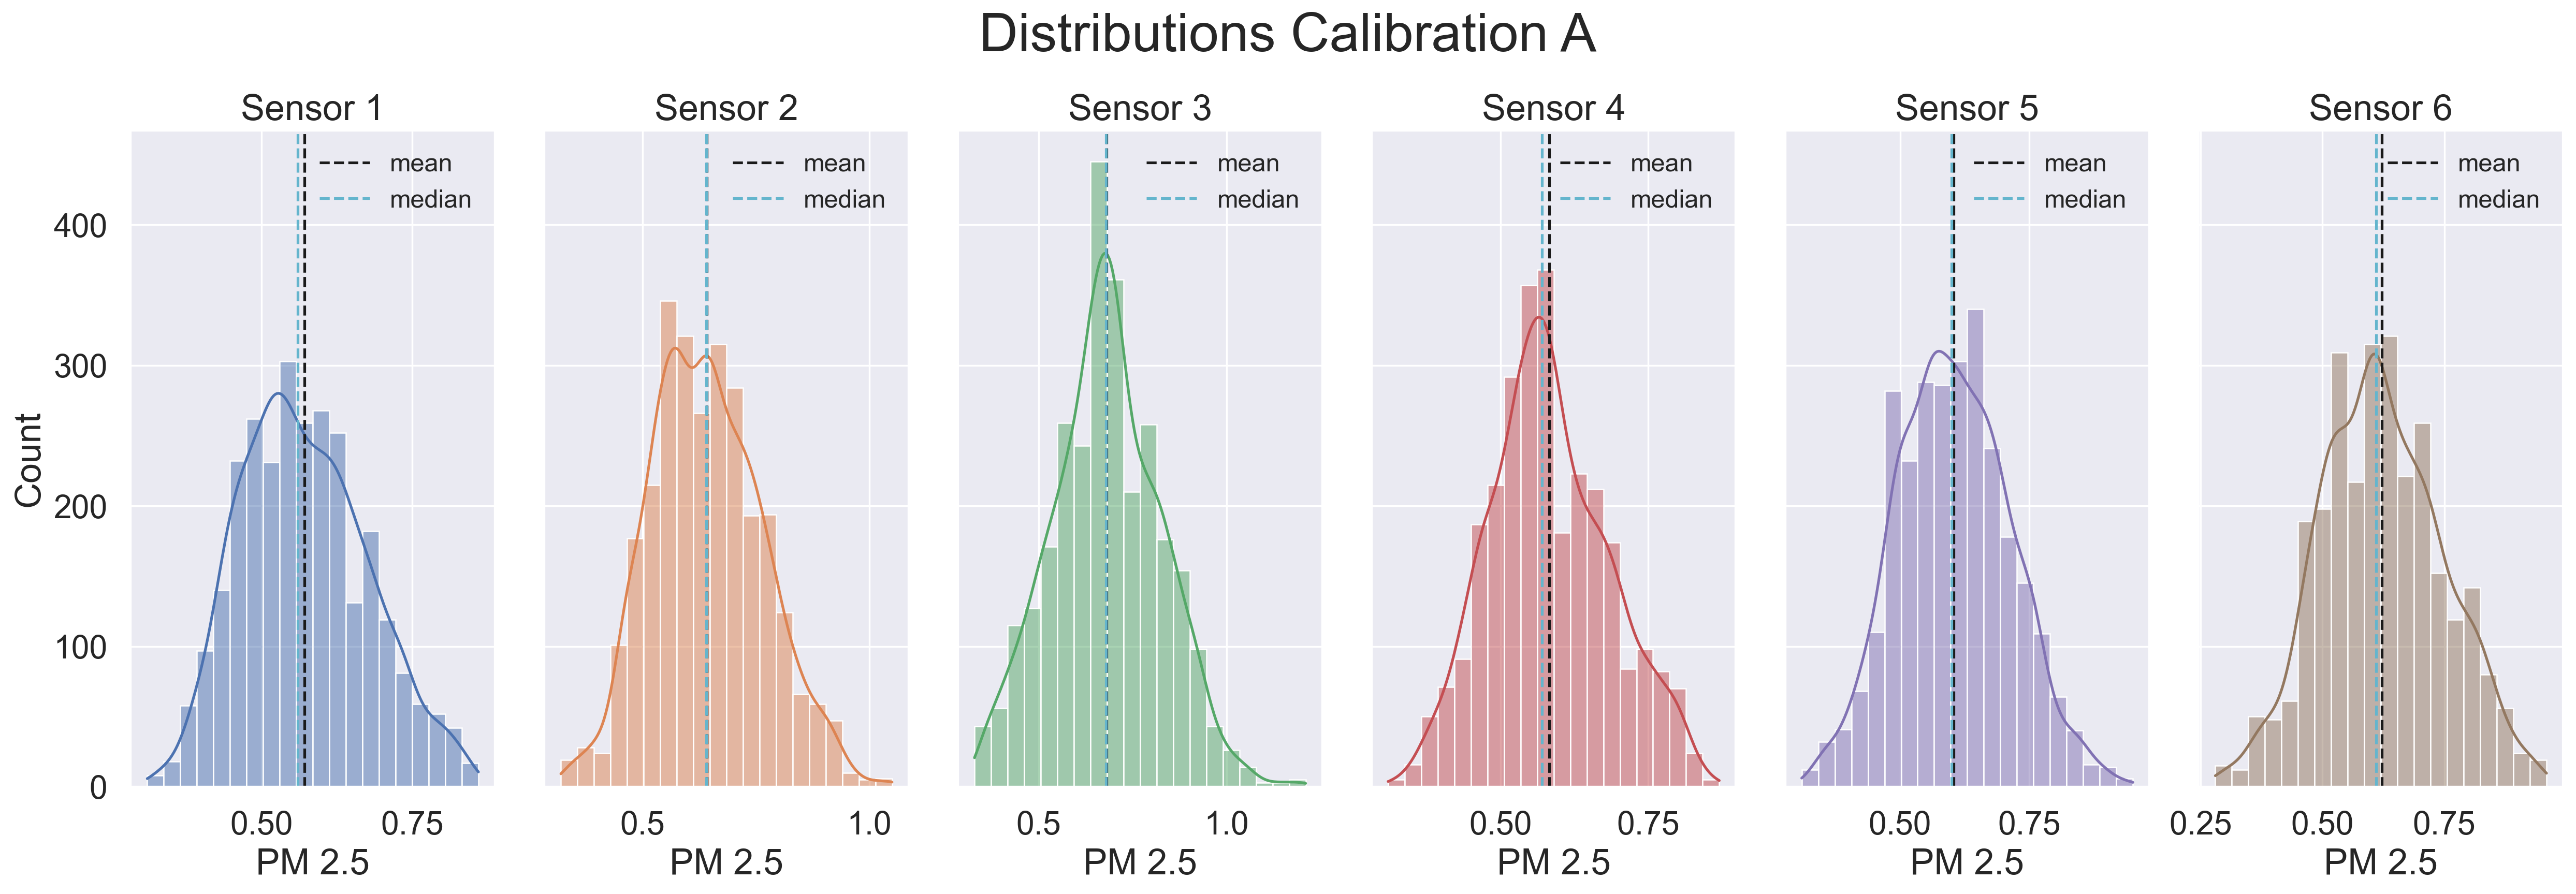

In [11]:
fig_name = False
plot_sensor_distributions(c_df, 'Distributions Calibration A', fig_name, bins=20)

**Comment**

This gives us a nice general overview of the individual sensor distributions. They seem to roughly follow normal distributions, but to what extent? To get more exact values, let's use QQ-plots, skew, and kurtosis.

### 3.4 Normal distribution

In [12]:
def skew(x):
    """A measure of dataset symmetry."""
    return stats.skew(x, bias=False)

def kurtosis(x):
    """A measure of outliers."""
    return stats.kurtosis(x, bias=False)

normal = c_df.groupby('Sensor').agg({'PM2.5': [skew, kurtosis]})

normal.head(10)

PM2.5          
            skew  kurtosis
Sensor                    
1       0.303538 -0.411906
2       0.256133 -0.184395
3       0.125521 -0.066265
4       0.232103 -0.322145
5       0.148537 -0.215805
6       0.112604 -0.300660

Compare with values

**Comment**

Sensor 1 has the highest absolute skew and kurtosis. Sensor 6 has the lowest skew while Sensor 3 has the least amount of kurtosis. This is interesting as Sensor 3 had the most outliers in numbers.

#### QQ Plots

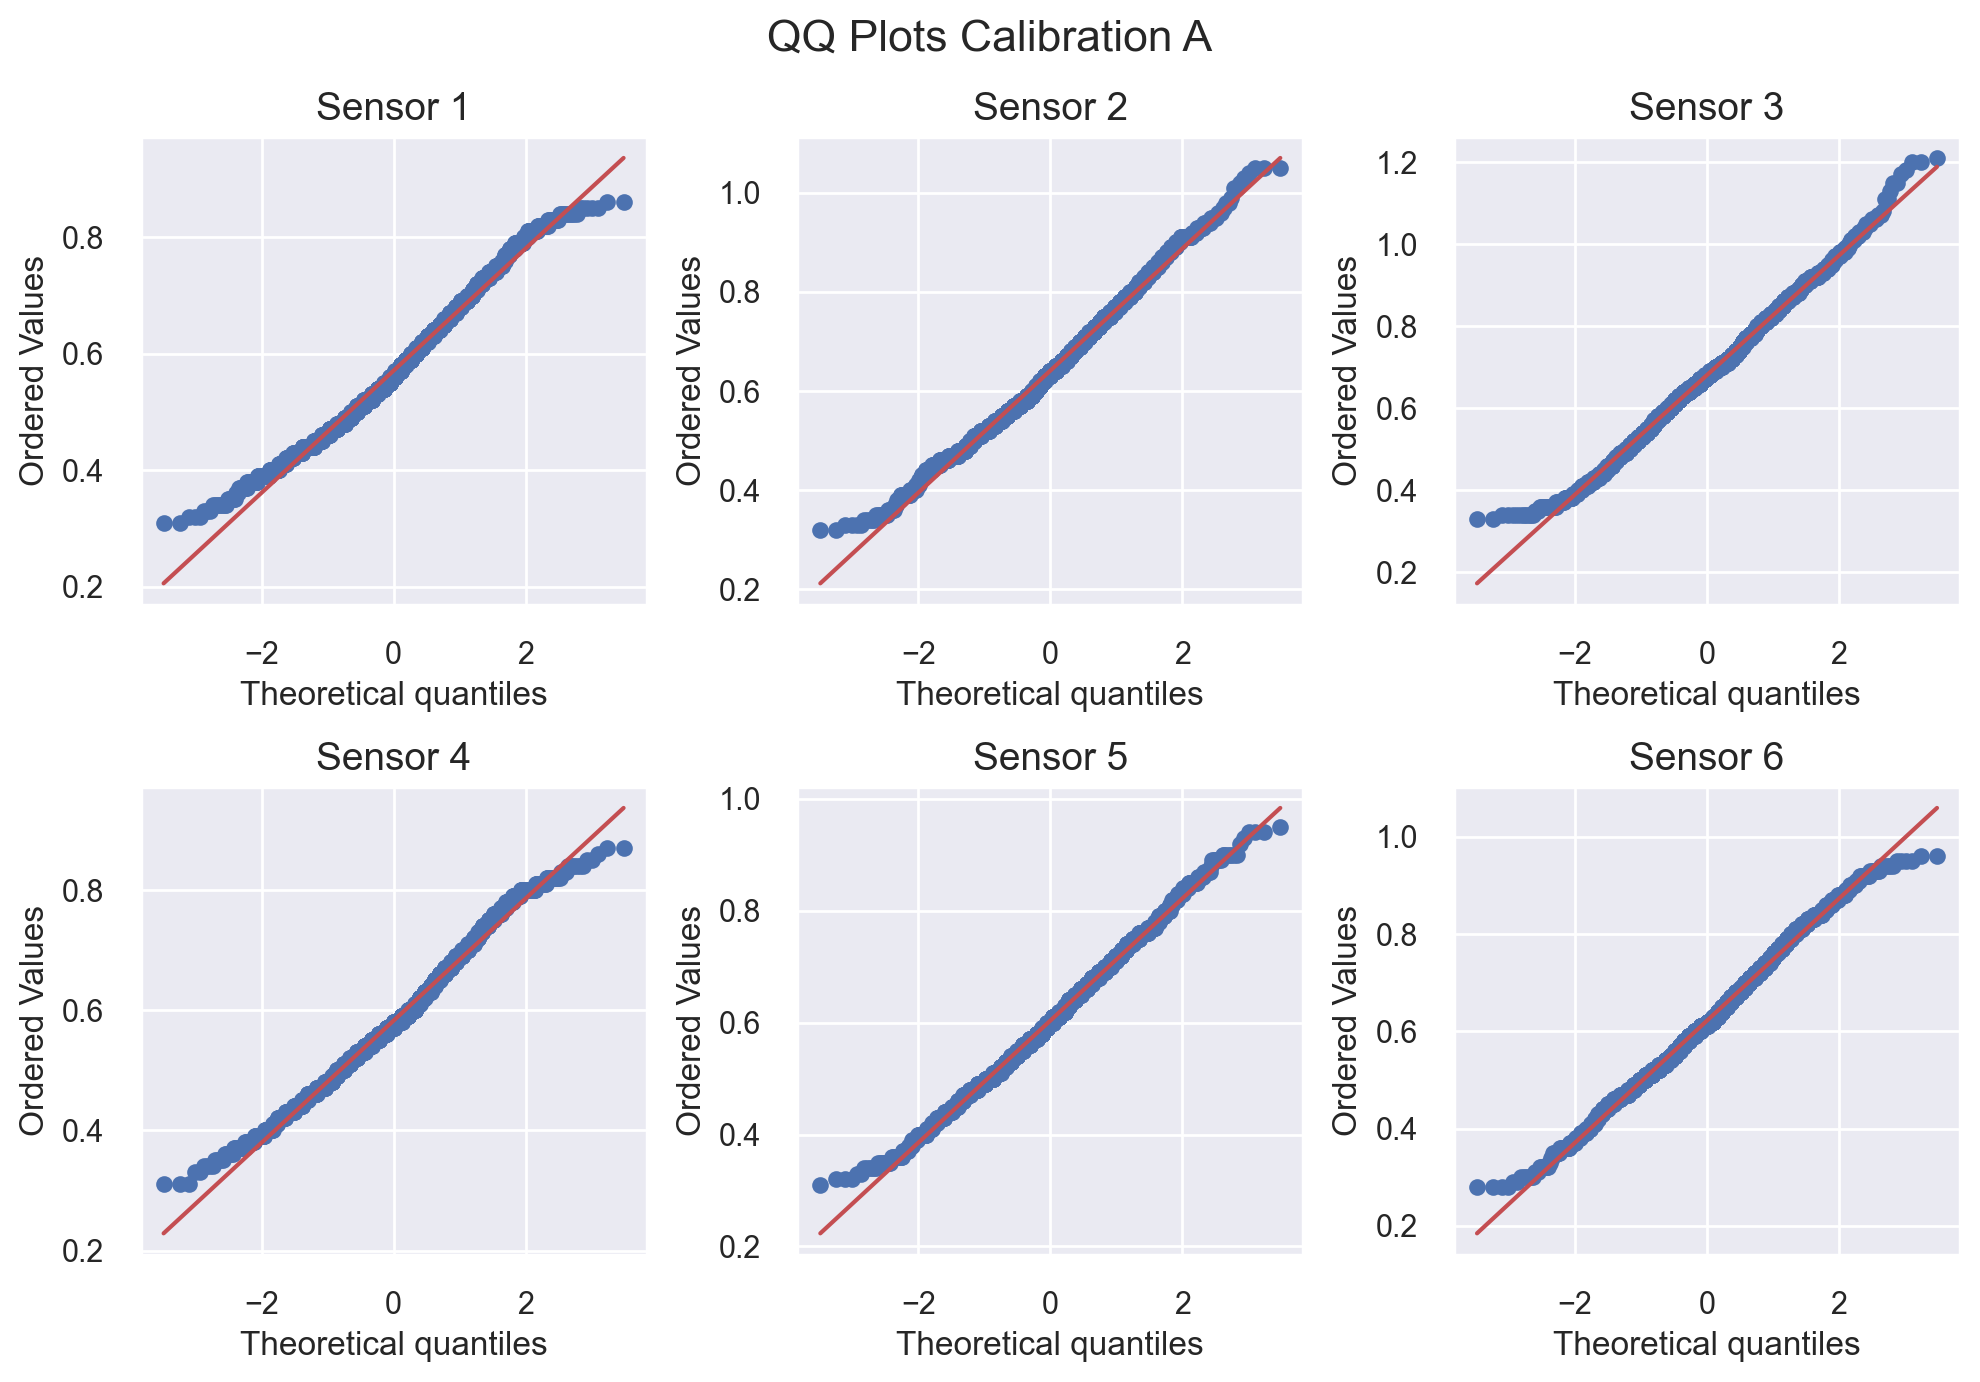

In [13]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(10, 7), dpi=200)

for sensor, ax in zip(c_df['Sensor'].unique(), axs.flatten()):
    stats.probplot(c_df[c_df['Sensor'] == sensor]['PM2.5'], dist='norm', plot=ax)
    ax.set_title(f'Sensor {sensor}', fontsize=14)

plt.suptitle('QQ Plots Calibration A', fontsize=16)
plt.tight_layout()

#plt.savefig(fig_folder + 'qq_plots.pdf')

plt.show()

**Comment**

Based on visuals from the above graphs, all sensors seem to follow a normal distribution quite well.

## 4 Comparison among sensors and between them

### 4.1 Distribution

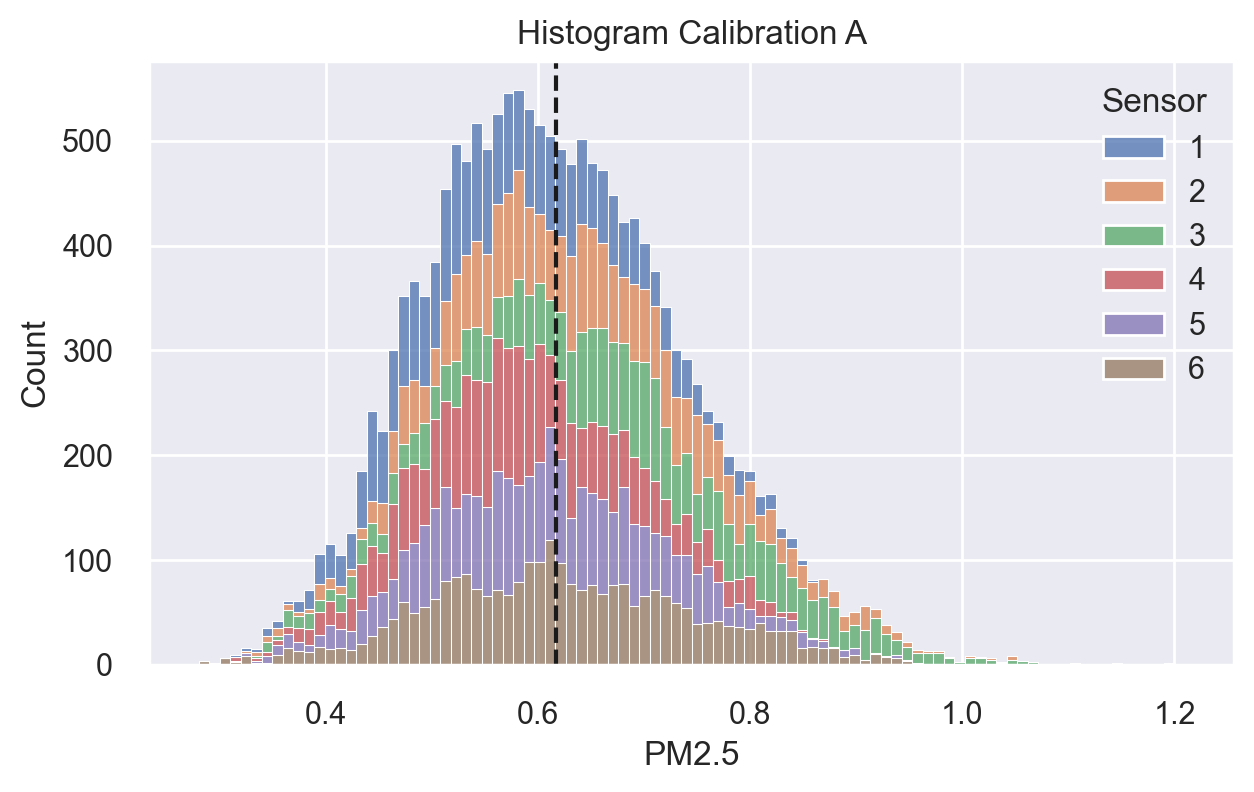

In [14]:
fig, ax = plt.subplots(figsize=[7,4], dpi=200)

sns.histplot(c_df, x='PM2.5', hue='Sensor', multiple='stack', bins=94)
plt.axvline(grand_mean, c='k', linestyle='--', label='mean', linewidth=1.5)
plt.title('Histogram Calibration A')

plt.show()

In [15]:
grand_skew = stats.skew(c_df['PM2.5'], bias=False)
grand_kurtosis = stats.kurtosis(c_df['PM2.5'], bias=False)

print(f'Skew: {grand_skew}')
print(f'Kurtosis: {grand_kurtosis}')
print(f'Std: {grand_std}')

Skew: 0.373857537365937
Kurtosis: 0.08151771399505581
Std: 0.125098579452895


**Comment**

Slightly longer tail on the right side (positive skew) than a normal distribution. Low kurtosis.

### 4.2 Standard deviations, etc.

The "grand std" shows how much every sample varies from the total mean. The coefficient of variation is computed as follows:

$$CV = \frac{\sigma}{grand\ mean}$$

In [16]:
CV = grand_std / grand_mean
CV

0.20280527532700063

*How much do the medians vary from the total median?* (same formula as standard deviation but with medians)

In [17]:
median_diff = 0

for sensor, grp in c_df.groupby('Sensor'):
    median_diff += (grp['PM2.5'].median() - grand_median) ** 2
    
median_diff = np.sqrt(median_diff / (len(c_df['Sensor'].unique()) - 1))

median_diff

0.0447213595499958

## 5 Other 

### 5.1 Pairplots

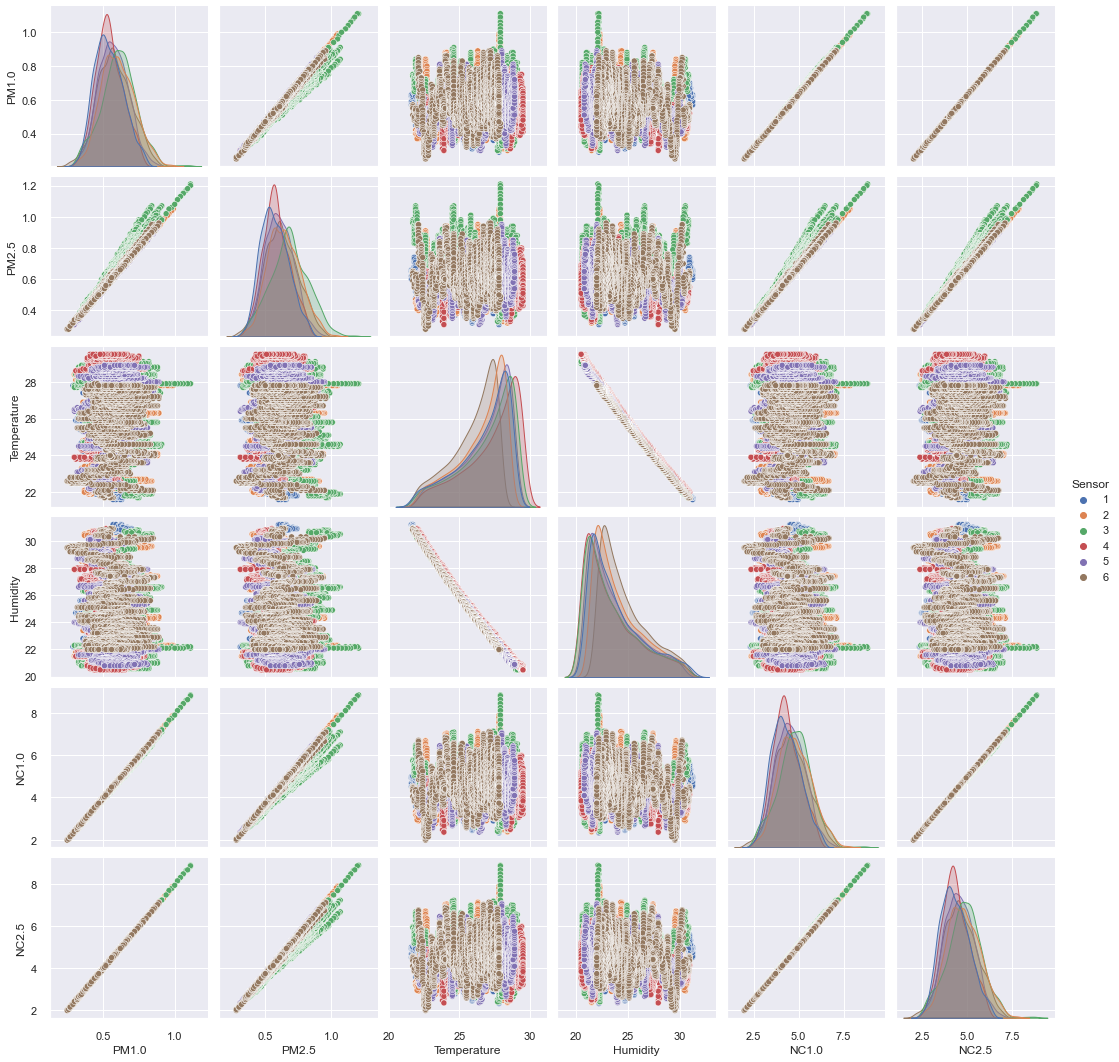

In [29]:
pair_df = get_calibrate_df()

pair_df = pair_df[['PM1.0', 'PM2.5', 'Temperature', 'Humidity', 'NC1.0', 'NC2.5', 'Sensor']]

sns.pairplot(pair_df, hue='Sensor')

#plt.savefig(fig_folder + 'pairplot.pdf')

# Box plot in stations

In [9]:
# Session df and raw session df
s_df = get_computed_sessions()
r_df = combine_raw_session_dfs()

r_df['Sensor'] = r_df['Sensor'].astype(str)

# Only keep green line
s_df = s_df[s_df['Station'].isin(get_green_line())]
r_df = r_df[r_df['Station'].isin(get_green_line())]

# Get session ids
session_ids = sorted(list(r_df["Session Id"].unique()))

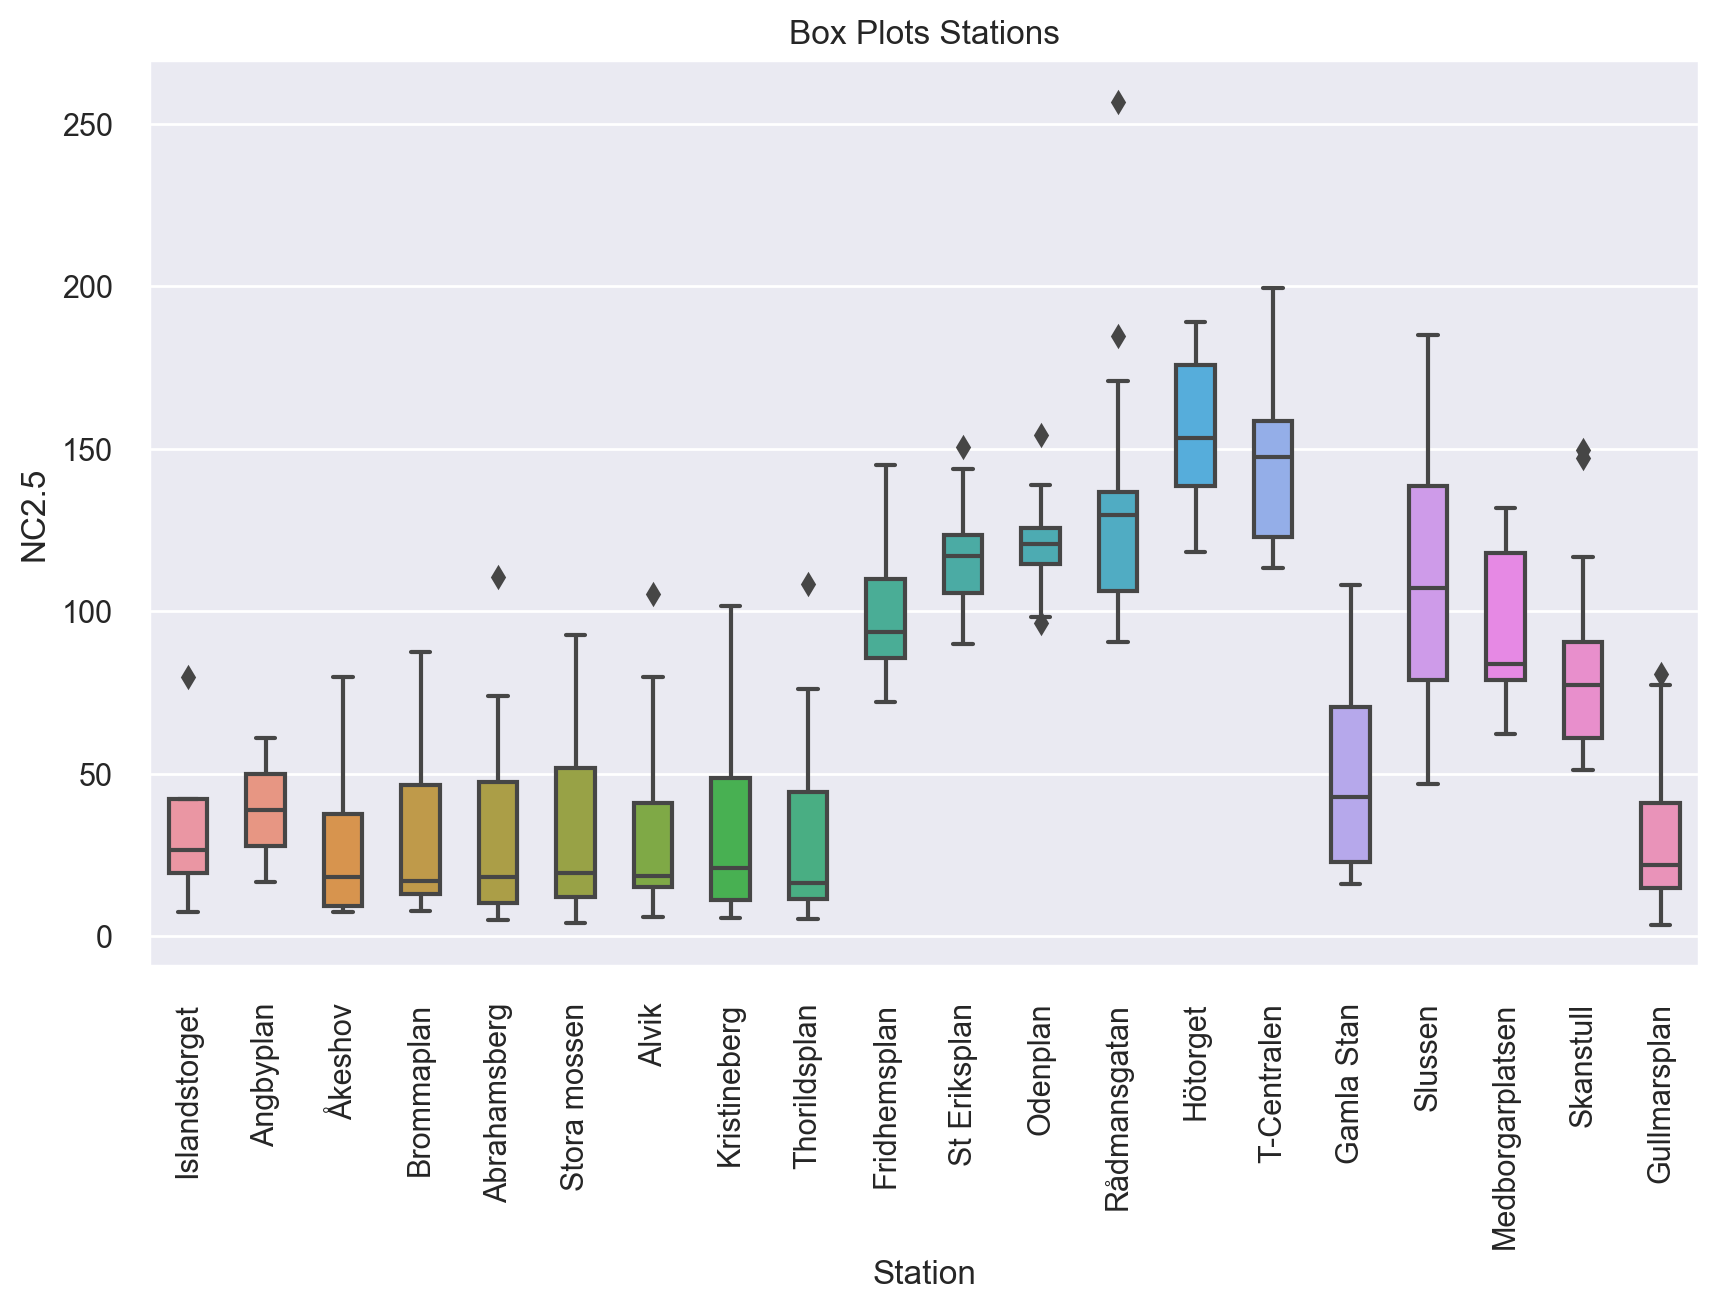

In [11]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

sns.boxplot(x='Station', y='NC2.5', data=s_df, width=0.5, order=get_green_line())
plt.xticks(rotation=90)
plt.title('Box Plots Stations')

#plt.axhline(10, c='r', linestyle=(0, (3, 10, 2, 3, 30, 1, 2, 1))) # dash dash dot dash densly dash
#plt.savefig('figures/PaperV1/Exploration/CalibrationA/box_plot.pdf')
plt.show()

**Comment**

There are some stations which have quite many outliers.

In [27]:
# Compute median, lower quartile, upper quartile, IQR, lower limit and upper limit
station_quantiles = s_df.groupby('Station').agg(
    {'PM2.5': 
     [Q1, Q2, Q3, IQR, lowerLimit, upperLimit, outliers, prcnt_outliers, 'count']
    }
)

station_quantiles['PM2.5'].sort_values(by='outliers', ascending=False)

,Q1,Q2,Q3,IQR,lowerLimit,upperLimit,outliers,prcnt_outliers,count
Station,,,,,,,,,
Alvik,2.377000,2.968000,5.495000,3.118000,-2.300000,10.172000,3.0,15.000000,20
Skanstull,12.240000,13.176000,15.735000,3.495000,6.997500,20.977500,2.0,11.764706,17
Gullmarsplan,2.857125,3.729250,5.646667,2.789542,-1.327188,9.830979,2.0,12.500000,16
Abrahamsberg,1.623667,2.426000,6.350000,4.726333,-5.465833,13.439500,1.0,9.090909,11
Kristineberg,2.064000,3.004000,6.478750,4.414750,-4.558125,13.100875,1.0,5.000000,20
Thorildsplan,2.170000,2.640000,6.418000,4.248000,-4.202000,12.790000,1.0,5.882353,17
St Eriksplan,23.487500,25.514667,27.202000,3.714500,17.915750,32.773750,1.0,5.000000,20
Rådmansgatan,22.420000,27.435000,32.610000,10.190000,7.135000,47.895000,1.0,5.882353,17
Åkeshov,1.494000,2.448000,5.020000,3.526000,-3.795000,10.309000,1.0,11.111111,9


**Comment**

Some stations have outliers. What happened during these sessions?

In [55]:
outlier_ids = print_outliers(s_df, station_quantiles, 'PM2.5')

=== OUTLIERS ===
Abrahamsberg:
	20211004-2 - PM2.5 = 14.66

Alvik:
	20211004-2 - PM2.5 = 14.0
	20211011-2 - PM2.5 = 10.62
	20211006-2 - PM2.5 = 10.18

Fridhemsplan:
	20211013-1 - PM2.5 = 33.31

Gullmarsplan:
	20211011-1 - PM2.5 = 10.78
	20211006-1 - PM2.5 = 10.28

Kristineberg:
	20211004-2 - PM2.5 = 13.5

Rådmansgatan:
	20210929-1 - PM2.5 = 60.05

Skanstull:
	20210930-3 - PM2.5 = 27.99
	20211004-1 - PM2.5 = 21.44

St Eriksplan:
	20211005-2 - PM2.5 = 16.0

Thorildsplan:
	20211004-2 - PM2.5 = 14.47

Åkeshov:
	20211004-2 - PM2.5 = 10.6

Unique outliers: ['20210929-1', '20210930-3', '20211004-1', '20211004-2', '20211005-2', '20211006-1', '20211006-2', '20211011-1', '20211011-2', '20211013-1']


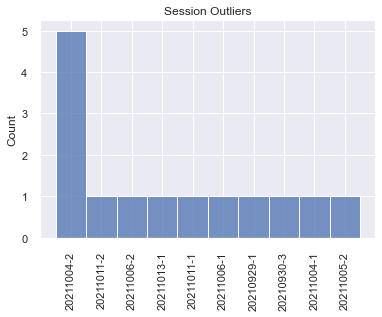

In [56]:
sns.histplot(outlier_ids)
plt.title('Session Outliers')
plt.xticks(rotation=90)
plt.show()

**Comment**

These sessions are worth examining and comparing with other sources. Especially session 20211004-2, as it contains 5 outliers within the same session!

# Station Distributions

- Get all raw data for a station and plot histograms etc. like calibration df

# Drift in sensors

### Per station

### Per sensor per station

In [39]:
station_data = {}

for sensor, grp in r_df.groupby('Sensor'):
    if sensor not in station_data:
        station_data[sensor] = {}
    
    for session_id, s_grp in grp.groupby('Session Id'):
        # get median value
        station_records = s_grp.loc[s_grp['Station'] == 'Rådmansgatan']
        
        if len(station_records) > 0:
            station_data[sensor][session_id] = station_records['PM2.5'].median()

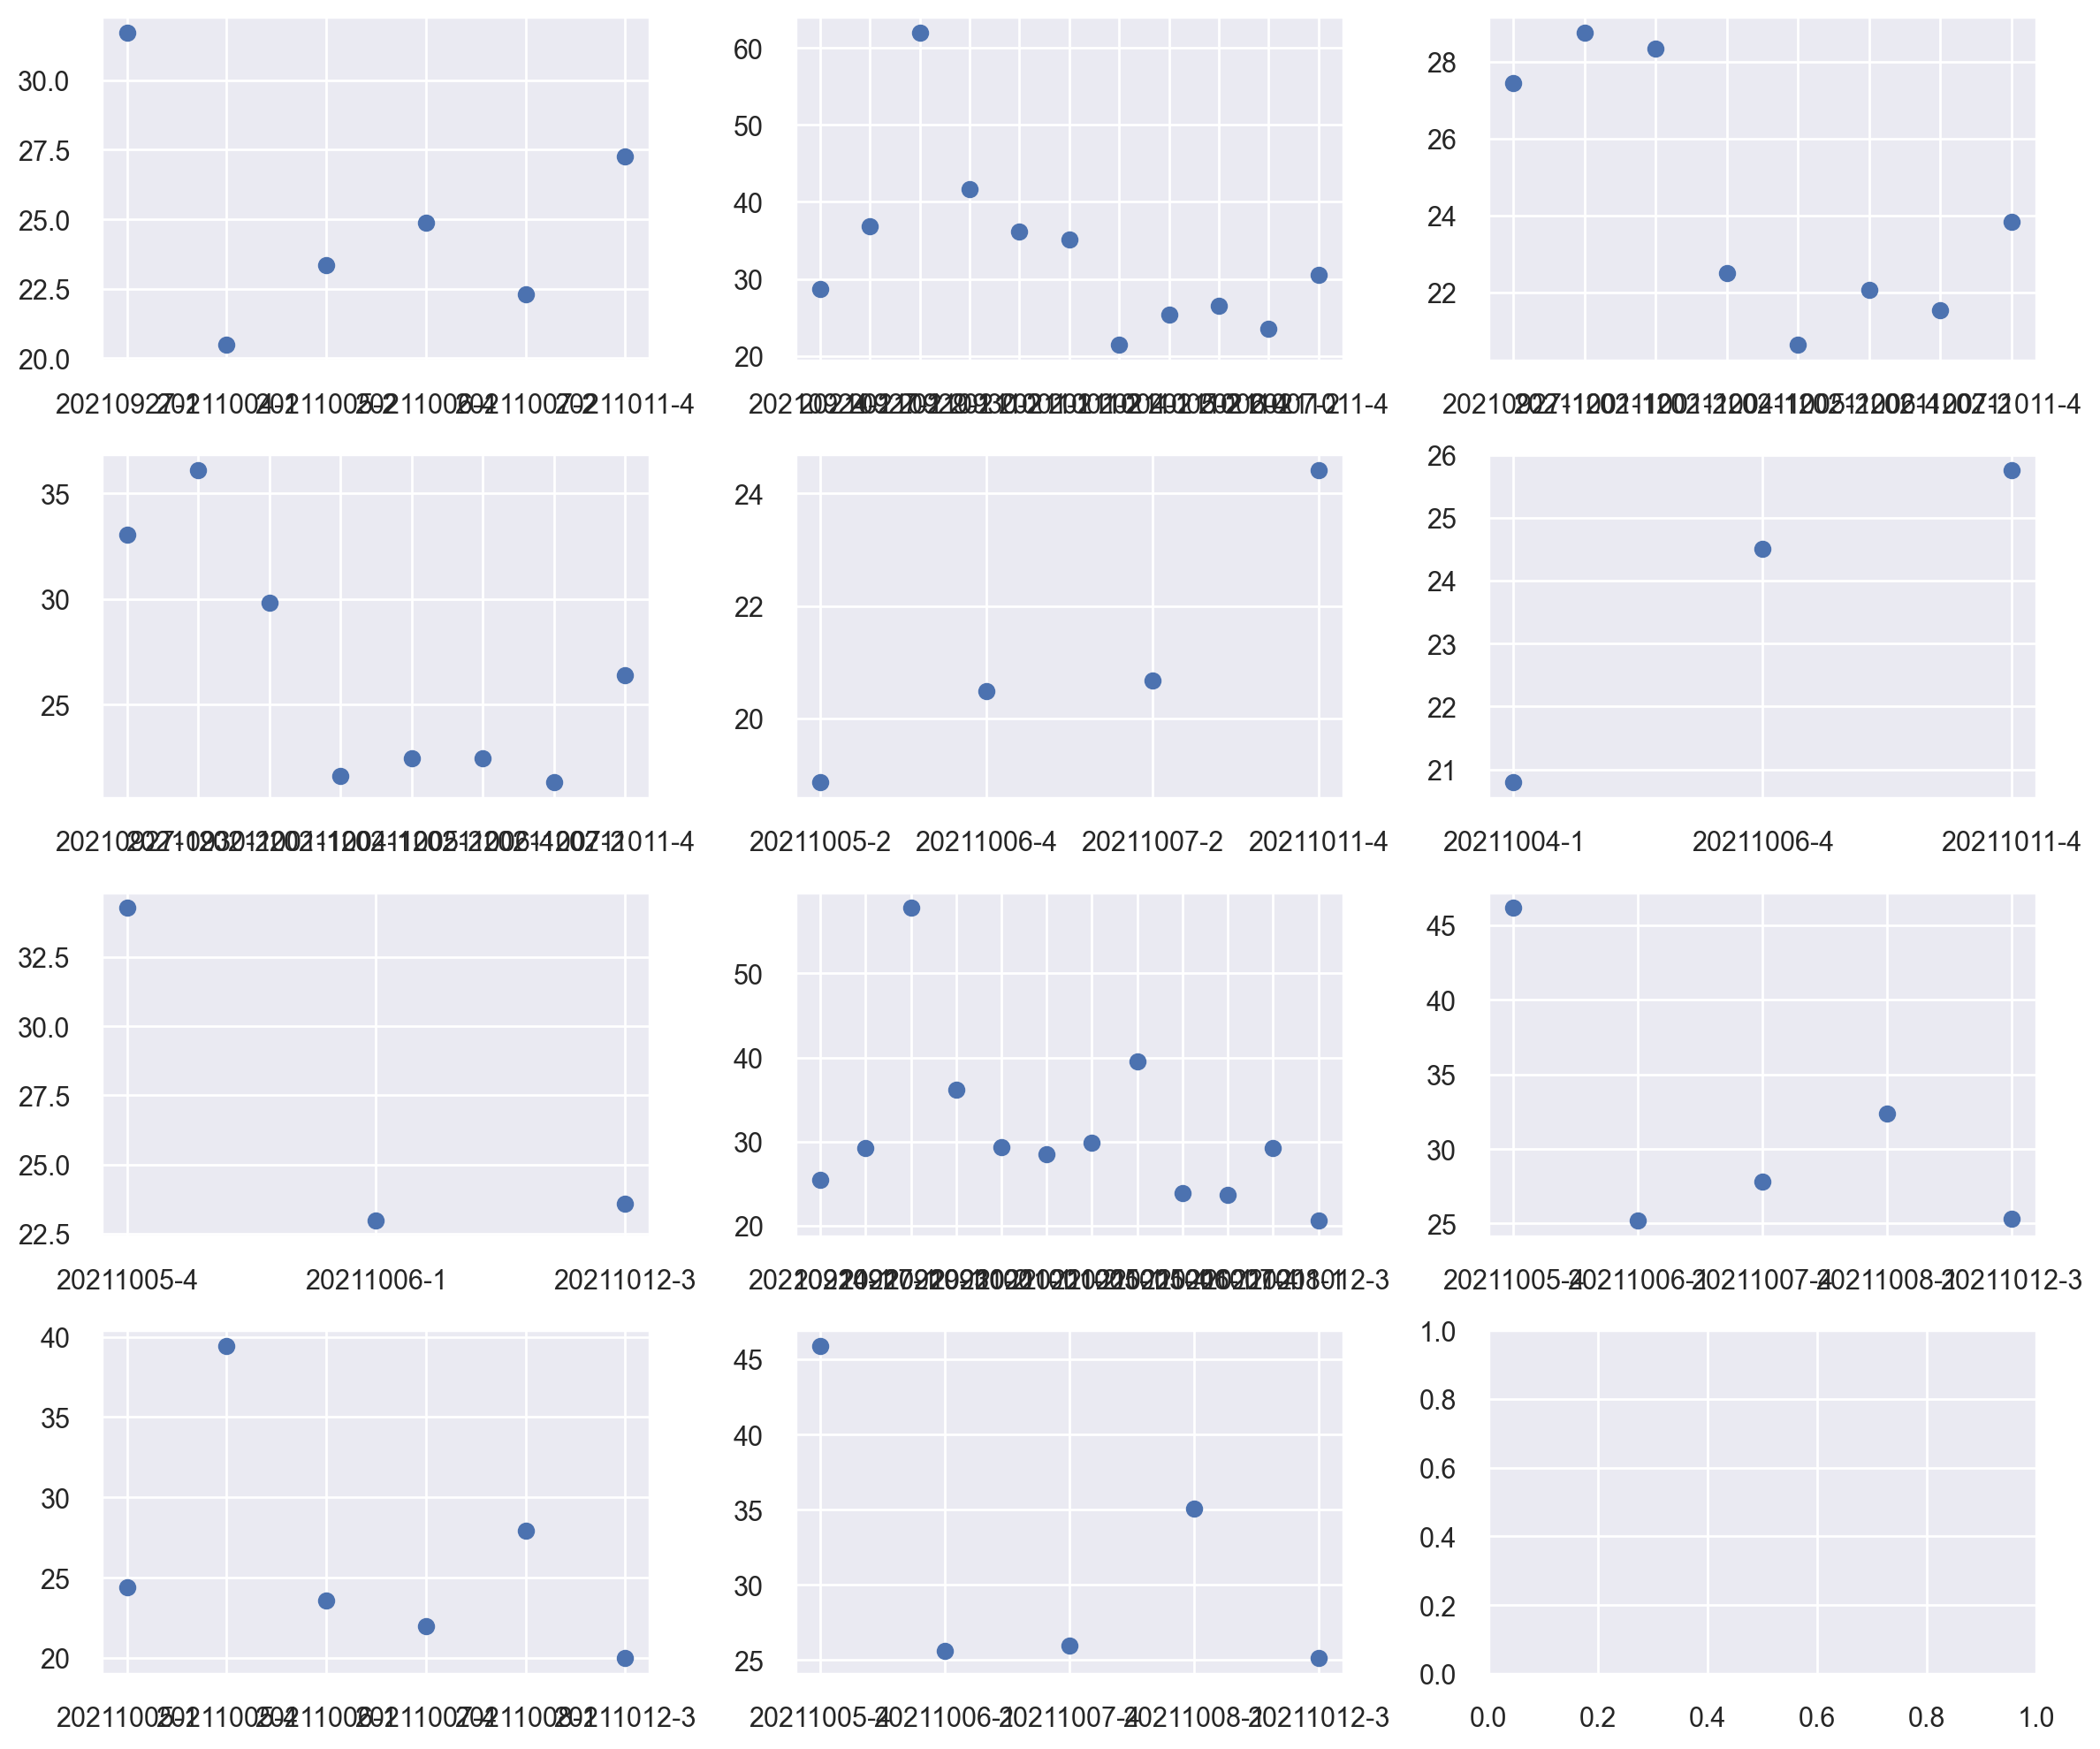

In [49]:
fig, axs = plt.subplots(figsize=[12,10], nrows=4, ncols=3, dpi=200)

for sensor, ax in zip(station_data.keys(), axs.flatten()):
    sorted_data = {k: v for k, v in sorted(station_data[sensor].items(), key=lambda item: item[0])}
    ax.scatter(sorted_data.keys(), sorted_data.values())
    
    #labels = r_df.loc[r_df['Sensor'] == sensor]['Session Id'].values
    #ax.set_xticklabels(labels, rotation=90)
    
plt.tight_layout()
plt.show()

In [61]:
#1234BD

# Comparison DiSC Data

In [67]:
# Session df and raw session df
s_df = get_computed_sessions()
r_df = combine_raw_session_dfs()

r_df['Sensor'] = r_df['Sensor'].astype(str)

# Only keep green line
s_df = s_df[s_df['Station'].isin(get_green_line())]
r_df = r_df[r_df['Station'].isin(get_green_line())]

# DiSC df and raw DiSC df
disc_df = get_computed_sessions('sessionsDiSC', disc=True)
raw_disc_df = combine_raw_session_dfs('sessionsDiSC')

disc_df = disc_df.loc[disc_df['Date'] != '2021-10-12']
raw_disc_df = raw_disc_df.loc[raw_disc_df['Date'] != '2021-10-12']

raw_disc_df['Sensor'] = raw_disc_df['Sensor'].astype(str)

# Only keep green line
disc_df = disc_df[disc_df['Station'].isin(get_green_line())]
raw_disc_df = raw_disc_df[raw_disc_df['Station'].isin(get_green_line())]

# Get session ids
session_ids = sorted(list(r_df["Session Id"].unique()))

In [68]:
disc_df['Date'].unique()

array(['2021-09-30', '2021-10-05', '2021-10-04', '2021-10-11',
       '2021-09-24', '2021-10-08', '2021-10-06', '2021-10-01',
       '2021-10-07', '2021-09-28', '2021-09-27', '2021-09-29'],
      dtype=object)

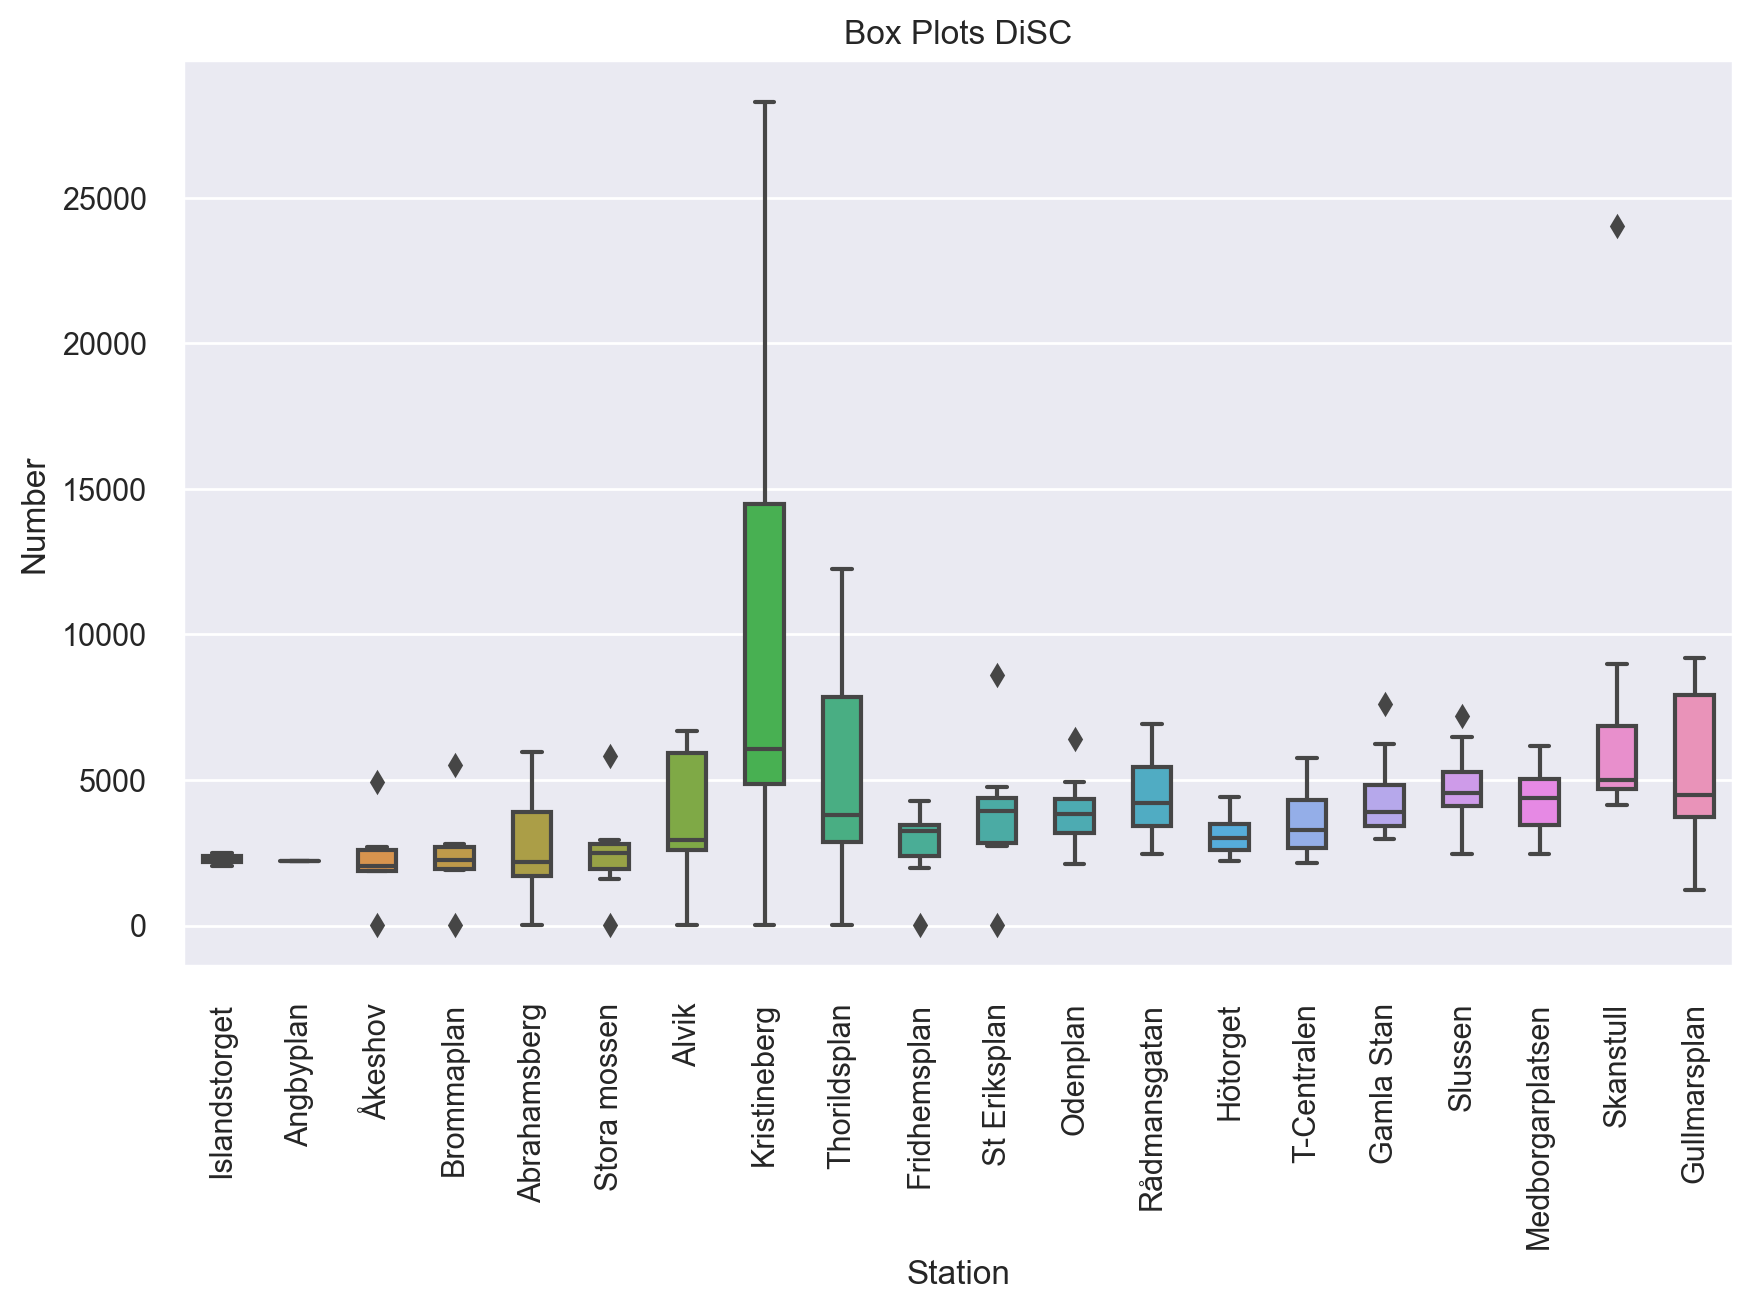

In [70]:
# DISC DF
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

sns.boxplot(x='Station', y='Number', data=disc_df, width=0.5, order=get_green_line())
plt.xticks(rotation=90)
plt.title('Box Plots DiSC')

plt.show()

In [51]:
# Compute median, lower quartile, upper quartile, IQR, lower limit and upper limit
d_station_quantiles = disc_df.groupby('Station').agg(
    {'Number': 
     [Q1, Q2, Q3, IQR, lowerLimit, upperLimit, outliers, prcnt_outliers, 'count']
    }
)

d_station_quantiles['Number'].sort_values(by='outliers', ascending=False)

,Q1,Q2,Q3,IQR,lowerLimit,upperLimit,outliers,prcnt_outliers,count
Station,,,,,,,,,
Åkeshov,1870.25,2055.5,2583.50,713.25,800.375,3653.375,2.0,33.333333,6
Brommaplan,1942.50,2244.0,2686.00,743.50,827.250,3801.250,2.0,28.571429,7
Stora mossen,1941.00,2485.0,2801.00,860.00,651.000,4091.000,2.0,28.571429,7
St Eriksplan,2888.50,3861.0,4314.25,1425.75,749.875,6452.875,2.0,14.285714,14
Skanstull,4695.00,4986.0,6854.00,2159.00,1456.500,10092.500,1.0,9.090909,11
Fridhemsplan,2433.50,3265.5,3625.25,1191.75,645.875,5412.875,1.0,7.142857,14
Gamla Stan,3424.00,3887.0,4820.00,1396.00,1330.000,6914.000,1.0,9.090909,11
Slussen,4111.50,4567.5,5289.00,1177.50,2345.250,7055.250,1.0,8.333333,12
Alvik,2608.50,4321.5,5965.00,3356.50,-2426.250,10999.750,1.0,7.142857,14


In [57]:
outlier_ids = print_outliers(disc_df, d_station_quantiles, 'Number')

=== OUTLIERS ===
Alvik:
	20211012-2 - Number = 40684.0

Brommaplan:
	20211006-3 - Number = 11.0
	20210929-2 - Number = 5503.0

Fridhemsplan:
	20211006-3 - Number = 11.0

Gamla Stan:
	20211008-1 - Number = 7616.0

Odenplan:
	20211001-3 - Number = 6397.0

Skanstull:
	20211005-1 - Number = 24044.0

Slussen:
	20211004-1 - Number = 7208.0

St Eriksplan:
	20211006-3 - Number = 11.0
	20211001-3 - Number = 8602.0

Stora mossen:
	20211006-3 - Number = 11.0
	20210929-2 - Number = 5828.0

Åkeshov:
	20211006-3 - Number = 11.0
	20210929-2 - Number = 4937.0

Unique outliers: ['20210929-2', '20211001-3', '20211004-1', '20211005-1', '20211006-3', '20211008-1', '20211012-2']


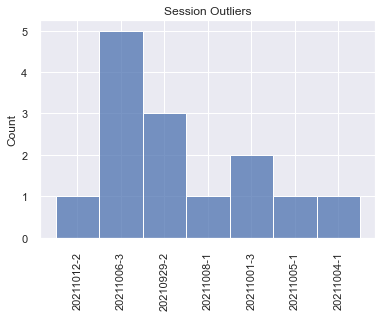

In [58]:
sns.histplot(outlier_ids)
plt.title('Session Outliers')
plt.xticks(rotation=90)
plt.show()

### Session Graphs

In [75]:
session = '20210930-1'

s1_df = r_df.loc[r_df['Session Id'] == session]
s2_df = raw_disc_df.loc[raw_disc_df['Session Id'] == session]

In [76]:
s2_df

,Time,Number,Size,LDSA,Filter,Diff,Timestamp,Station,Date,Sensor,Session Id
112,854.5,1921,"72,1","8,05","7,21","2,37",2021-09-30 07:22:04,Abrahamsberg,2021-09-30,DiSC,20210930-1
113,864.5,1930,"71,3","7,99","7,13","2,37",2021-09-30 07:22:14,Abrahamsberg,2021-09-30,DiSC,20210930-1
114,874.5,1845,"74,3",8,"7,21","2,31",2021-09-30 07:22:24,Abrahamsberg,2021-09-30,DiSC,20210930-1
115,884.5,1997,"70,9","8,22","7,33","2,45",2021-09-30 07:22:34,Abrahamsberg,2021-09-30,DiSC,20210930-1
116,894.5,1972,"70,4","8,05","7,17","2,41",2021-09-30 07:22:44,Abrahamsberg,2021-09-30,DiSC,20210930-1
...,...,...,...,...,...,...,...,...,...,...,...
332,424.5,1851,"72,2","7,77","6,96","2,29",2021-09-30 07:14:54,Åkeshov,2021-09-30,DiSC,20210930-1
333,434.5,1917,"71,8",8,"7,16","2,36",2021-09-30 07:15:04,Åkeshov,2021-09-30,DiSC,20210930-1
334,444.5,2078,"69,1","8,3","7,36","2,52",2021-09-30 07:15:14,Åkeshov,2021-09-30,DiSC,20210930-1
335,454.5,2018,"69,7","8,15","7,24","2,46",2021-09-30 07:15:24,Åkeshov,2021-09-30,DiSC,20210930-1
